**Grace Moberg**

Spring 2023

CS 252: Mathematical Data Analysis and Visualization

Project 3: Linear regression

QR-based linear regression and polynomial regression

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import data
import linear_regression

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Notes

- In your implementations, only the following "high level" `scipy`/`numpy` functions can be used:
    - `np.linalg.inv`
    - `scipy.linalg.lstsq` (in `LinearRegression::linear_regression_scipy` only).
    - `np.linalg.norm`
    - `scipy.linalg.solve_triangular`, 

## Task 4: Implement a QR based linear regression solver

### 4a) QR-decomposition

- Write algorithm to compute QR decomposition (`linear_regression::qr_decomposition`). **Run test code below.** Equation for R: $$R = Q^TA$$
- Implement `linear_regression::linear_regression_qr` to use the QR decomposition to do the linear regression. Recall that the equation is $$Rc = Q^Ty$$ which can be solved without taking the inverse of $R$ through backsolving.

#### Test QR decomposition

In [2]:
iris_filename = 'data/iris.csv'
iris_data = data.Data(iris_filename)

A = iris_data.select_data(['sepal_length', 'petal_width'])
A1 = np.hstack([A, np.ones([len(A), 1])])

lin_reg_qr = linear_regression.LinearRegression(iris_data)
myQ, myR = lin_reg_qr.qr_decomposition(A1)

Q, R = np.linalg.qr(A1)

print('NOTE: It is ok if numbers match but whole columns are negated.\n')
print(f'Your Q shape is {myQ.shape} and should be {Q.shape}')
print(f'Your R shape is {myR.shape} and should be {R.shape}')
print(f'1st few rows of your Q are\n{myQ[:3]} and should be\n{Q[:3]}')
print(f'\nYour R is\n{myR[:5]} and should be\n{R[:5]}')

NOTE: It is ok if numbers match but whole columns are negated.

Your Q shape is (150, 3) and should be (150, 3)
Your R shape is (3, 3) and should be (3, 3)
1st few rows of your Q are
[[ 0.07056 -0.11765  0.00009]
 [ 0.0678  -0.11202  0.0339 ]
 [ 0.06503 -0.10638  0.06772]] and should be
[[-0.07056 -0.11765 -0.00009]
 [-0.0678  -0.11202 -0.0339 ]
 [-0.06503 -0.10638 -0.06772]]

Your R is
[[72.27621 15.60873 12.12709]
 [-0.       7.66143 -1.22542]
 [-0.      -0.       1.19668]] and should be
[[-72.27621 -15.60873 -12.12709]
 [  0.        7.66143  -1.22542]
 [  0.        0.       -1.19668]]


#### Test linear regression via QR decomposition

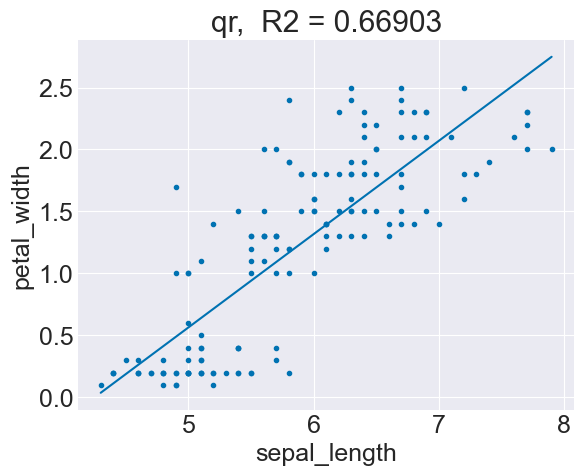

In [3]:
lin_reg_qr.linear_regression(['sepal_length'], 'petal_width', 'qr')
lin_reg_qr.scatter('sepal_length', 'petal_width', 'qr')
lin_reg_qr.show()

**Question 4:** How do your results compare to the built-in SciPy solver? Is this what you expected? Why or why not?

**Answer 4:** The R^2 value is identical for this method and the built-in SciPy solver. I expected it to be very close since all three methods of solving should use the same process, but may have varying speeds.

### Task 4b) Compare performance of the linear regression methods

- In the cell below, load in the brain network `brain.csv` dataset.
- Create `Data` and `LinearRegression` objects.
- Load in the list of variable names in the brain dataset (62)
- Do multiple linear regressions, separately for each of the linear regression methods that you have implemented (including `scipy`): Set all brain data variables except for the last one as the independent variables, the last variable is the depenendent variable.
- Compute and print the mean squared error (MSE) in the predictions made by each linear regression model and the actual y values.

In [4]:
brain_data = data.Data('data/brain.csv')
lin_reg_brain = linear_regression.LinearRegression(brain_data)
brain_names = brain_data.get_headers()
lin_reg_brain.linear_regression(brain_names[:-1], brain_names[-1], 'scipy')
scipy_mse = lin_reg_brain.mse
lin_reg_brain.linear_regression(brain_names[:-1], brain_names[-1], 'normal')
normal_mse = lin_reg_brain.mse
lin_reg_brain.linear_regression(brain_names[:-1], brain_names[-1], 'qr')
qr_mse = lin_reg_brain.mse
print('Scipy MSE: ', scipy_mse)
print('Normal MSE: ', normal_mse)
print('QR MSE: ', qr_mse)

Scipy MSE:  1.4544299507041264e-25
Normal MSE:  28805.331779715314
QR MSE:  3.218663262520503e-24


**Question 5:** What are the mean squared errors for each of the regression methods on the brain data? Which method(s) do best and which do the worst **and why**?

**Answer 5:** Rounded MSE for all three methods is 1483.4062. The MSE for the SciPy solver differs only in the very last decimal place, which is so insignificant it may as well be exactly equal. The MSE being essentially equal is sensible given that all three methods had the same R^2 value.

## Task 5: Polynomial Regression

We have been creating linear regression fits of form $y =c_0 + c_1x_1 + c_2x_2 + \ldots$, where $x_i$ are independent variables (columns of $A$) and $c_i$ are corresponding coefficients in $c$. However, this equation only allows us to fit data with a line/plane. This may not be the best choice for all datasets.

In this task, you will generalize the linear regression model form to include higher-degree (>1) polynomial terms and explore how this may improve fits to complex data. For example, assume we're doing a simple linear regression with independent variable $x_1$ and dependent variable $y$. A linear regression that fits data with a quadratic shape has the form$$y = c_0 + c_1x_1 + c_2x_1^2$$ 

Complete the following steps to add support for polynomial regression in your `LinearRegression` class.

### 5a) Build the polynomial matrix of the independent variable

The polynomial matrix contains the independent variable raised to a different power in each column. For example, if $A$ originally has a column vector for the independent variable $\vec{x_1}$ ($A = [\vec{x_1}]$) and we wanted to make the above quadratic model, we would append $x_1^2$ ($A = [\vec{x_1}, \vec{x_1^2}]$).

**TODO:**
Implement and test `LinearRegression::make_polynomial_matrix` (*helper method*) that takes care of raising the independent variable samples to different powers.

##### Test `make_polynomial_matrix`

In [5]:
test_A = np.r_[1:10].reshape((9, 1))
test_p = 3

# Test cubic
lin_reg = linear_regression.LinearRegression(data.Data())
print(f'Your polynomial matrix:\n{lin_reg.make_polynomial_matrix(test_A, 3)}')

true_mat = '''
[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]
 [  6.  36. 216.]
 [  7.  49. 343.]
 [  8.  64. 512.]
 [  9.  81. 729.]]
'''
print('It should look like:\n', true_mat)

Your polynomial matrix:
[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]
 [  6.  36. 216.]
 [  7.  49. 343.]
 [  8.  64. 512.]
 [  9.  81. 729.]]
It should look like:
 
[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]
 [  6.  36. 216.]
 [  7.  49. 343.]
 [  8.  64. 512.]
 [  9.  81. 729.]]



### 5b) Add support for polynomial regression

This can be performed in 3 steps:

1. Implement the `LinearRegression::polynomial_regression` method to perform the polynomial regression (*alternate option: you may instead update your `linear_regression` method. If you decide to go this route, add a keyword argument for the polynomial degree with a default value of 1 to preserve compatability with regular linear regression.*).
    - I suggest using your QR solver, but you could use any of the ones you have implemented.
2. Update `LinearRegression::predict`: Run `make_polynomial_matrix` on the "A" matrix that enters into the computation $y = Ac$ if `self.p > 1`.
3. Add support for plotting polynomials in `LinearRegression::scatter` by generalizing the plotted regression line to a regression polynomial if `self.p > 1`:
    - Getting your polynomial "x" values: Run `make_polynomial_matrix` on your evenly-spaced line sample points. To get the shapes to work out, you may need to add a trailing singleton dimension to your "x" sample points. For example, if you have 1000 "x" sample points, make the shape `(1000, 1)` rather than `(1000,)`.
    - Getting your polynomial "y" values: Use matrix multiplication with your polynomial regression model slopes and/or intercepts.

*There is no explicit test code here — visualizing the fit in the next subtask will help you debug!*

### 5c) Run a polynomial regression

In this subtask, you will debug your polynomial regression implementation and experiment fitting some data with it.

#### Test: Polynomial regression with linear model ($p = 1$)

- In the cell below, fit the `poly_data.csv` dataset using polynomial regression where the polynomial degree $p = 1$. Use your QR solver.
- Use `scatter` to plot the results.
- Print out the mean squared error.

The plot created by running the below cell should "look right" to you.

MSE:  71.81095209669246


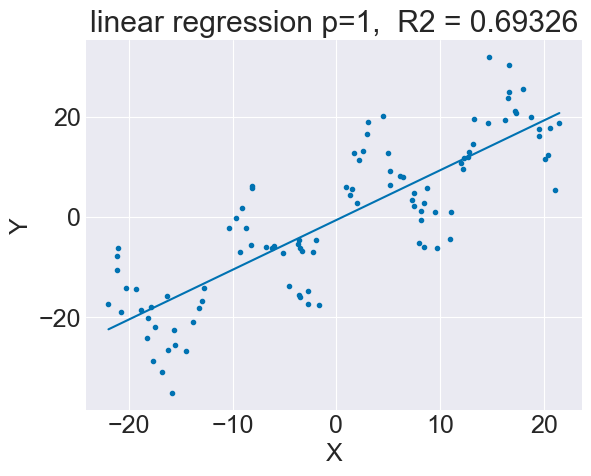

In [6]:
poly_data = data.Data('data/poly_data.csv')
poly_reg = linear_regression.LinearRegression(poly_data)
poly_reg.poly_regression('X','Y',1)
poly_reg.scatter('X', 'Y', title = 'linear regression p=1')
print('MSE: ', poly_reg.mse)

#### Test: polynomial regression with high degree polynomials

Repeat the steps from the $p = 1$ test above in the cell below, but this time try $p = 15$. 

*Your regression fit should not be a line!*

MSE:  15.929358390771547


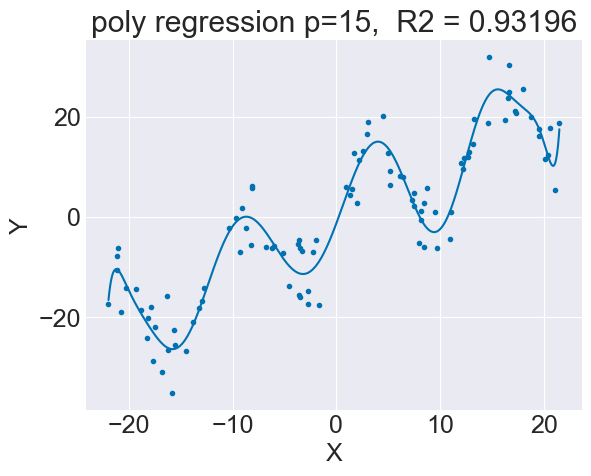

In [7]:
poly_reg.poly_regression('X','Y',15)
poly_reg.scatter('X', 'Y', title = 'poly regression p=15')
print('MSE: ', poly_reg.mse)

MSE:  18.571763838774086


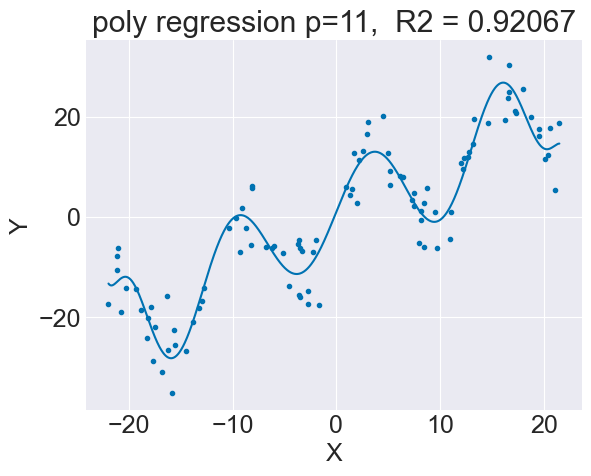

In [8]:
poly_reg.poly_regression('X','Y',11)
poly_reg.scatter('X', 'Y', title = 'poly regression p=11')
print('MSE: ', poly_reg.mse)

**Question 6:** Describe the fit compared to `p=1` — is it better or worse? Why?

**Question 7:** Describe what happens visually and in terms of the $R^2$ and MSE values as you experiment with the polynomial degree between 1 and 15.

**Answer 6:** Based on R^2 and MSE, the fit is much better for p=15 than for p=1. This is unsurprising since the shape of the data seems entirely non-linear, so a higher-degree polynomial fit will be able to approximate the shape better.

**Answer 7:** 
As the degree approaches 15, the regression curve fits closer to the data points and has a greater number of local minima and maxima. R^2 gets closer to 1 and MSE gets lower as the degree of the polynomial is increased as well.

## Task 6: Overfitting

In this task, you will experiment with how polynomial regression generals to data not used to fit the regression model.

### 6a) Create fit and validation sets

The `poly_data.csv` dataset has 100 samples ($N=100$). In the cell below, split these samples into two separate "datasets" and create 2 `Data` objects representing:
- The first 50% of samples will be used to fit the regression model (i.e. run linear regression on these samples). We will call this the **fit set** (data used to fit the regression).
- The second 50% of samples will be set aside and only used to check how well the fitted regression generalizes to new data. We will call this the **validation set**.

The data samples are already shuffled.

*Hint: There is a helpful `Data` method for paring down a dataset into a certain range of samples.*

In [9]:
fit_data = data.Data('data/poly_data.csv')
fit_data.limit_samples(0, 49)
print(fit_data)
valid_data = data.Data('data/poly_data.csv')
valid_data.limit_samples(50, 99)
print(valid_data)

data/poly_data.csv (49x2)
Headers: 
	X	Y
 ---------------------------- 
Showing first 5/49 rows 
2.147	11.382	
9.465	1.034	
4.52	20.251	
1.974	2.89	
-3.358	-6.809	

data/poly_data.csv (49x2)
Headers: 
	X	Y
 ---------------------------- 
Showing first 5/49 rows 
-3.65	-4.658	
9.69	-6.107	
-21.986	-17.271	
-8.694	-2.22	
-15.536	-25.608	



Printing the `Data` object storing the fit set should yield:

    -------------------------------
    data/polydata.csv (50x2)
    Headers:
    X	Y
    -------------------------------
    Showing first 5/50 rows.
    2.147	11.382
    9.465	1.034
    4.52	20.251
    1.974	2.89
    -3.358	-6.809

    -------------------------------

Printing the `Data` object storing the validation set should yield:

    -------------------------------
    data/polydata.csv (50x2)
    Headers:
    X	Y
    -------------------------------
    Showing first 5/50 rows.
    -3.65	-4.658
    9.69	-6.107
    -21.986	-17.271
    -8.694	-2.22
    -15.536	-25.608

    -------------------------------

### 6b) Check fit generalization on validation set

Here is the process for checking how well your fitted linear regression model generalizes to the validation data:
1. Create `Data` objects for both the fit and validation data sets (*as you have already done*).
2. Run linear regression on the fit set.
3. Create a new `LinearRegression` object associated with the validation data.
4. Copy over the fitted slope and intercept coefficients associated with the fit set to the validation set `LinearRegression` object.
5. Create a scatterplot by calling `scatter` to show the validation data and the regression curve that uses the coefficients fitted on the fit dataset (copied over in Step 4).
6. Calculate and report fit statistics (e.g. MSE, $R^2$).

Before doing this, implement the following methods to help you copy over the fitted slope, intercept and other data from your fit set `LinearRegression` object:

- `get_fitted_slope`: return the fitted regression slopes.
- `get_fitted_intercept`: return the fitted regression intercept.
- `initialize(ind_vars, dep_var, slope, intercept, p)`: set fields based on passed in parameter values.

#### Check overfitting with $p = 15$ polynomial regression model

In the cell below:

1. Fit a polynomial regression model with $p = 15$ on the fit set.
2. Create 2 scatter plots:
    - Showing the fit set and regression curve fitted to it.
    - Showing the validation set and regression curve that uses the fitted coefficients to the **fit set**.
3. Compute and print the MSE for both the fit and validation sets.

Use the 6 step process above to guide you through the setup.

MSE:  12.003318932603941


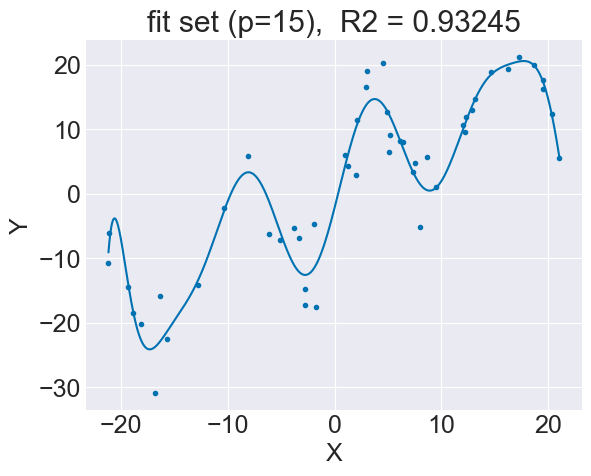

In [10]:
lin_reg_fit = linear_regression.LinearRegression(fit_data)
lin_reg_fit.poly_regression('X','Y', p=15)
lin_reg_fit.scatter('X','Y', 'fit set (p=15)')
print('MSE: ', lin_reg_fit.mse)

MSE:  63.27391639881203


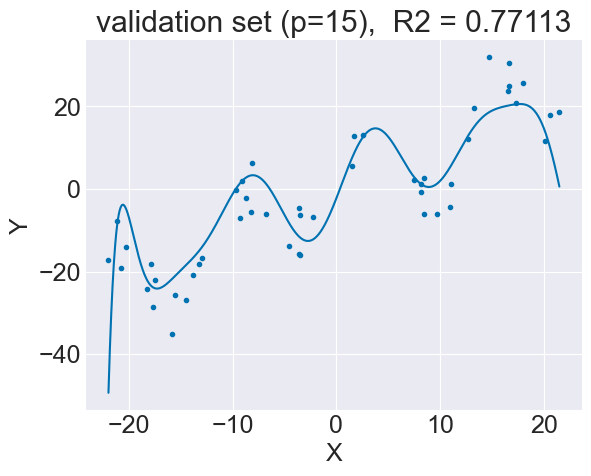

In [11]:
lin_reg_valid = linear_regression.LinearRegression(valid_data)
lin_reg_valid.initialize(ind_vars = ['X'], dep_var = 'Y', slope = lin_reg_fit.get_fitted_slope(), intercept = lin_reg_fit.get_fitted_intercept(), p=lin_reg_fit.p)
lin_reg_valid.scatter('X','Y','validation set (p=15)')
print('MSE: ', lin_reg_valid.mse)

MSE:  63.27391639881203


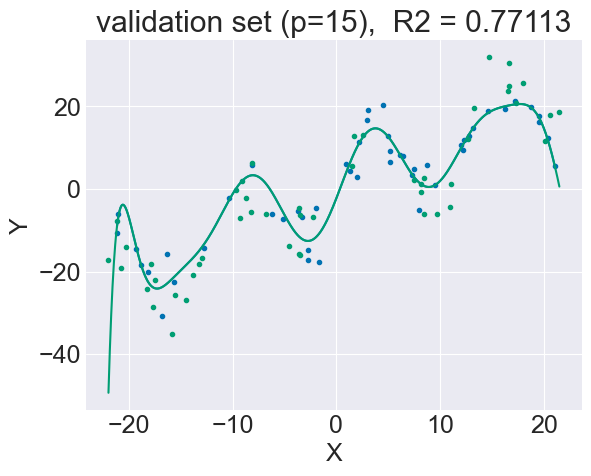

In [12]:
lin_reg_fit = linear_regression.LinearRegression(fit_data)
lin_reg_fit.poly_regression('X','Y', p=15)
lin_reg_fit.scatter('X','Y', 'fit set (p=15)')
# print('MSE: ', lin_reg_fit.mse)

lin_reg_valid = linear_regression.LinearRegression(valid_data)
lin_reg_valid.initialize('X', 'Y', lin_reg_fit.get_fitted_slope(), lin_reg_fit.get_fitted_intercept(), p=lin_reg_fit.p)
lin_reg_valid.scatter('X','Y','validation set (p=15)')
print('MSE: ', lin_reg_valid.mse)

**Question 8:** Describe how the fitted coefficients obtained for the fit set generalize to the validation set. Do they do a good or bad job? Why?

**Question 9:** Does the generalization improve or worsen for polynomial degrees < 15? Are Back up your observations with numbers (e.g. MSE).

**Question 10:** Are there any values/ranges of polynomial degrees that generalize acceptably to the validation set? Why do you think so?

**Question 11:** What happens when you increase the polynomial degree much above 15? Why do you think this happens? Back up your observations with numbers (e.g. MSE).

**Answer 8:** 
The fitted coefficients do a reasonable job with generalizing to the validation set, as the R^2 value is 0.771 which is decent although naturally not as good as the fit set, which has an R^2 value of 0.932. The difference between these two R^2 values is not insignificant, but the fit set does not do a "poor" job of modeling the validation set.

**Answer 9:** 
It depends. Values prior to p=9 tend to be not as good, but setting p=9 gives the best possible generalization with a MSE of 38.306 and R^2 of 0.861. Values higher than p=9 tend to not be as good as p=9.

**Answer 10:** 
I think p=9 generalizes acceptably enough because R^2=0.861 which is less than 0.1 off the R^2 value for the fit set, and the MSE is 38.3 which isn't terrible.

**Answer 11:**
When you increase the polynomial degree above 15, the MSE gets exceedingly large (to values as large as 323). This is because we are encountering the problem of over-fitting the fit set so that it doesn't predict the validation set as well.

## Extensions

To receive credit for any extension, you must:
- Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
- **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
- Include (*labeled!*) plots and/or numbers to present your results.
- Write up your extensions below or in a separate notebook.

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

**Reminder:** Give credit to all sources, including anyone that you consulted.

## Extension: Matrix Condition Number

For an extension, I decided to implement functions to find the matrix condition number. A matrix condition number is essentially a measure of how much output of a matrix can change from only a small error in the input. In the case of this project, matrix condition number is relevant because it can be used to measure the quality of a matrix for solving a linear regression. A condition number close to 1 means the matrix is well-conditioned, whereas a number of extremely large magnitude means a matrix is ill-conditioned. If a matrix is ill-conditioned, the least-squares regression solution will be volatile to small numerical errors – especially if computed using matrix inverse – and there may be great fluctuations across the various solution methods. Matrix condition number can be calculated as
$$\kappa(A) = ||A|| \cdot ||A^{-1}||. $$
However, in the case that $A$ is not square, the matrix condition number can still be calculated using a Moore-Penrose pseudoinverse for a rectangular matrix. This idea can be implemented by adapting singular value decomposition of a matrix.

### Singular Value Decomposition & Pseudoinverse

The singular value decomposition of a matrix is the generalization of eigendecomposition for non-square matrices. It can be written as $$ A = U \Sigma V^T $$ assuming $A$ is real. For our purposes, $A$ is always real so we proceed with this formula. Details of $U$, $V$, and $\Sigma$ are given in the attached code. 

After computing the SVD, we can utilize all three matrices to compute the pseudoinverse. The pseudoinverse is given by $$A^{+} = VD^{+}U.T,$$
where $V = V.T$ from the SVD, $U.T = U.T$ from the SVD, and $D^{+}$ is the pseudoinverse of $\Sigma$. However, since $\Sigma$ is diagonal, we can create its pseudoinverse by creating a diagonal matrix from $\Sigma$, putting the reciprocal of each element on the diagonal, and transposing it.

To compute the matrix condition number and pseudoinverse, I created a number of helper methods, one for each matrix of the singular value decomposition, one to compute the pseudoinverse, and a final one to actually compute the condition number. Details can be found in the bottom of the linear_regression.py file.

##### References: 
https://en.wikipedia.org/wiki/Condition_number

http://www.numerical-methods.com/lineq/Condition%20Number%20of%20a%20Matrix.pdf

https://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm

The majority of the datasets we looked at have relatively small matrix condition numbers for the size of the datasets, meaning that they are fairly suitable for linear regression and all methods should be fairly similar. Consider the brain data that we earlier compared MSE for each method on.

In [31]:
brain_data = data.Data('data/brain.csv')
brain_reg = linear_regression.LinearRegression(brain_data)
bData = brain_data.select_data(brain_data.get_headers())
print('Condition number: ', brain_reg.cond(bData))

Condition number:  1630.431083842689


A condition number of 1630 is relatively small considering the size of the brain data set. Then, it is fairly sensible that the MSE computed for all three different methods is nearly identical. If a dataset had a significantly large matrix condition number, we would expect the QR decomposition method to perform much better because it does not require taking an inverse, which tends to be the operation that is most affected by small numerical errors.

However, even very small matrices can have large condition numbers. Consider the following 2x2 matrix, which has a high condition number for its size.

In [7]:
mata = np.array([[4.1,2.8],[9.7,6.6]])
brain_reg.cond(mata)

1623.0000000000011

A 6x6 matrix with a high condition number is shown below. Interestingly, despite the poor condition number, selecting any one column to be the 'dependent variable' and making the other 5 columns independent actually turns out to be a near-perfect linear relationship. Neverthless, observe the fact that the magnitude of error for the 'normal' method is 5 degrees higher than for the QR decomposition. Since using the normal equation requires taking an inverse, with a more ill-conditioned matrix, it makes sense that the error would be higher (although the error for all 3 is exceptionally small nonetheless).

In [12]:
test_data = data.Data('data/mini_test.csv')
print(test_data)
test_reg = linear_regression.LinearRegression(test_data)
dat = test_data.select_data(test_data.get_headers())
test_reg.cond(dat)
test_reg.linear_regression(['X1','X3','X4','X5','X6'],'X2','scipy')
print('scipy mse: ', test_reg.mse)
print('scipy R2: ', test_reg.R2)
test_reg.linear_regression(['X1','X3','X4','X5','X6'],'X2','normal')
print('normal mse: ', test_reg.mse)
print('normal R2: ', test_reg.R2)
test_reg.linear_regression(['X1','X3','X4','X5','X6'],'X2','qr')
print('qr mse: ', test_reg.mse)
print('qr R2: ', test_reg.R2)

data/mini_test.csv (6x6)
Headers: 
	X1	X2	X3	X4	X5	X6
 ---------------------------- 
Showing first 5/6 rows 
1.0	3.0	11.0	0.0	-11.0	-15.0	
18.0	55.0	209.0	15.0	-198.0	-277.0	
-23.0	-33.0	144.0	532.0	259.0	82.0	
9.0	55.0	405.0	437.0	-100.0	-285.0	
3.0	-4.0	-111.0	-180.0	39.0	219.0	

scipy mse:  6.292349010495401e-26
scipy R2:  1.0
normal mse:  9.79764152680371e-19
normal R2:  1.0
qr mse:  1.805705767494517e-24
qr R2:  1.0


## Extension: Power Plant Data

For the last project, I looked at some associations between data from a power plant. Below is the description of the variables again, for reference:

The data set I am going to analyze is the Combined Cycle Power Plant data set, which contains 9568 data points collected from a Turkish power plant when it was set to work a full load. There are five features in the data set, four of which were collected with the hope of predicting the fifth. 

Explanatory variables:
1) Temperature (AT): measured in degrees celsius, ranging from 1.81 to 37.11
2) Ambient Pressure (AP): measured in millibars, ranging from 992.89-1033.30
3) Relative Humidity (RH): percentage, ranging from 25.56% to 100.16%
4) Exhaust Vacuum (V): measured in cm Hg (centimeters of mercury), ranging from 25.36-81.56

Response variable:
1) Net hourly electrical energy output (PE): measured in megawatts, ranging from 420.26-495.76

Last time, looking at only individual variables paired with output, no one variable was able to predict PE very well. However, I would anticipate that looking at the combination of all four explanatory variables will allow a fairly accurate prediction of output. 
I will test out all three models to see if any one performs better than the others.

In [20]:
power_data = data.Data('data/ccpp.csv')
power_reg = linear_regression.LinearRegression(power_data)
headers = power_data.get_headers()
print(headers)
power_reg.linear_regression(['AT','V','AP','RH'],'PE','scipy')
print('scipy mse: ', power_reg.mse)
print('scipy R2: ', power_reg.R2)
power_reg.linear_regression(['AT','V','AP','RH'],'PE','normal')
print('normal mse: ', power_reg.mse)
print('normal R2: ', power_reg.R2)
power_reg.linear_regression(['AT','V','AP','RH'],'PE','qr')
print('qr mse: ', power_reg.mse)
print('qr R2: ', power_reg.R2)

['AT', 'V', 'AP', 'RH', 'PE']
scipy mse:  20.76739812708614
scipy R2:  0.9286960829246874
normal mse:  20.767398127086146
normal R2:  0.9286960829246874
qr mse:  20.767398127086135
qr R2:  0.9286960829246874


As predicted, taking into account all four explanatory variables allows for fairly minimal MSE and fairly high R2 value, meaning that the linear regression model overall does quite a good job of predicting output utilizing all four variables.

Out of curiosity, let's look at the pair plots of all variables with linear regression lines overlaid.

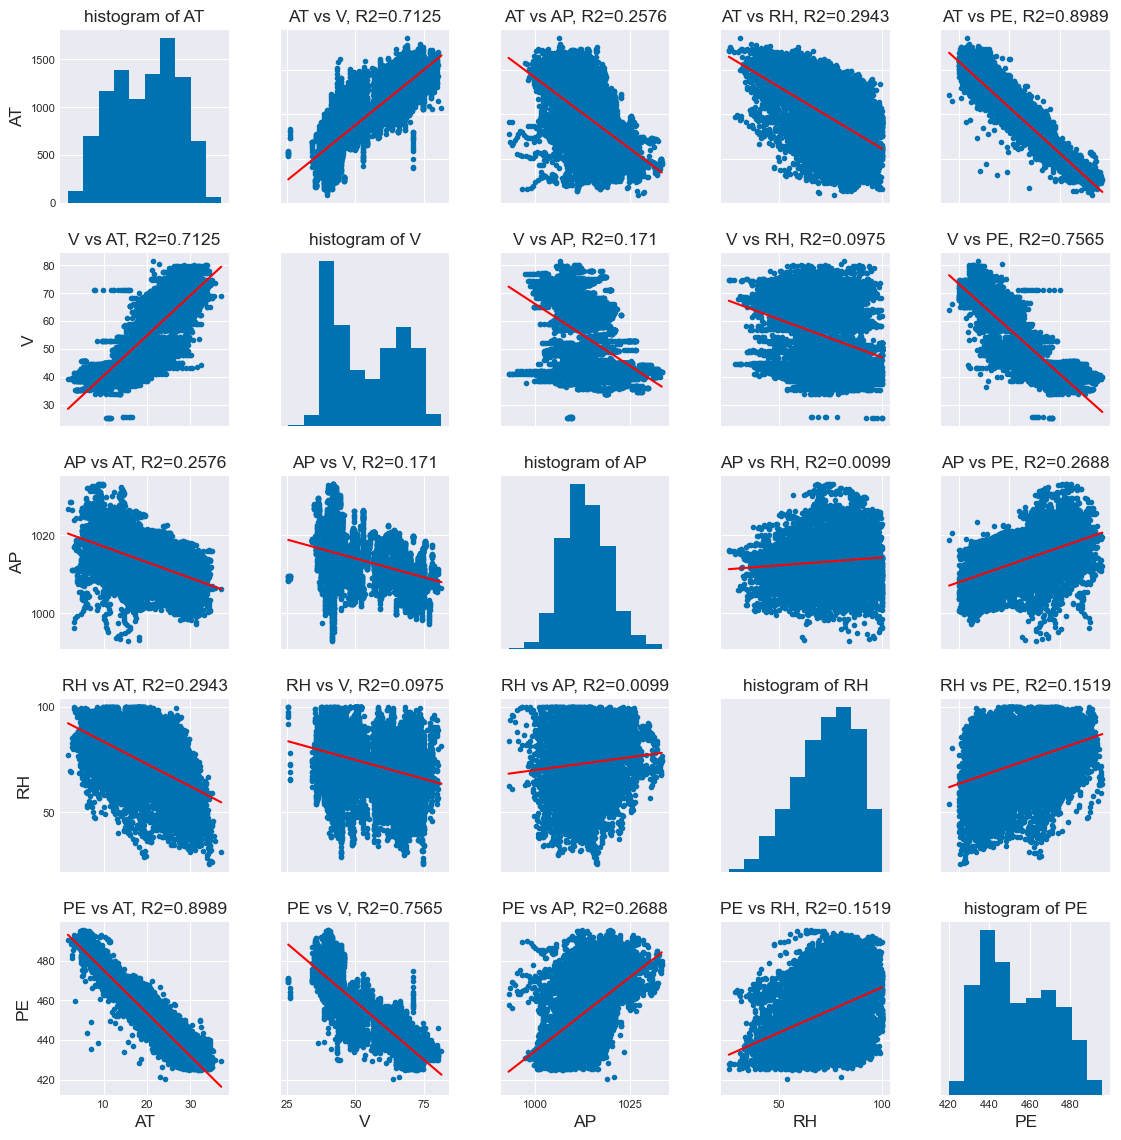

In [23]:
power_reg.pair_plot(headers, hists_on_diag=True)

As observed in the previous project, the two variables with the strongest correlation are PE (output) and AT (temperature). They have a fairly clear inverse relationship, so an increase in temperature corresponds to a decrease in output. The R2 value for these two variables is 0.8989, making it clearly the best single predictor of output. However, this value is still less than the R2 value of 0.928 obtained when all four explanatory variables are taken into account.

### 1. Your own data

- Run linear regression on datasets that interest you. Identify your hypotheses about the association between variables and test them out. Make plots and report all relevant metrics fit.

### 2. Linear regression algorithm comparison

- Compare the linear regression methods that you implemented on a dataset of your choice.
- Research and implement matrix condition number. Find a dataset with a poor matrix condition number and then compare the regression methods. Which does best and why?

### 3. Confidence intervals or other kinds of error bars on linear regression plots

- Add the option to plot 95% confidence intervals on the linear regression predictions in your plot functions (e.g. `scatter`). [This website](https://real-statistics.com/regression/confidence-and-prediction-intervals/) should be a helpful reference.

### 4. Overfitting

- Run polynomial regression on other datasets. What degree polynomial works well? When do you overfit?

### 5. Stepwise linear regression

- Implement the stepwise linear regression discussed in class where you add variables to the regression model one-by-one in a greedy fashion: each variable added out of the available ones not already entered in the regression should result in the largest increase in the adjusted $R^2$ value on the validation data.